## Importamos librerías y dataset

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# 1) Describimos el dataset

In [3]:
print('Train set size:  ', X_train.shape)
print('Test set size:   ', X_test.shape)

Train set size:   (60000, 28, 28)
Test set size:    (10000, 28, 28)


Graficamos, iterando con la ayuda del amigo chat gpt

/var/folders/w2/38zz5scj7lq_rpnmpknfg8mh0000gn/T/ipykernel_3271/3844854881.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Labels', y='Values', data=data, palette='viridis')


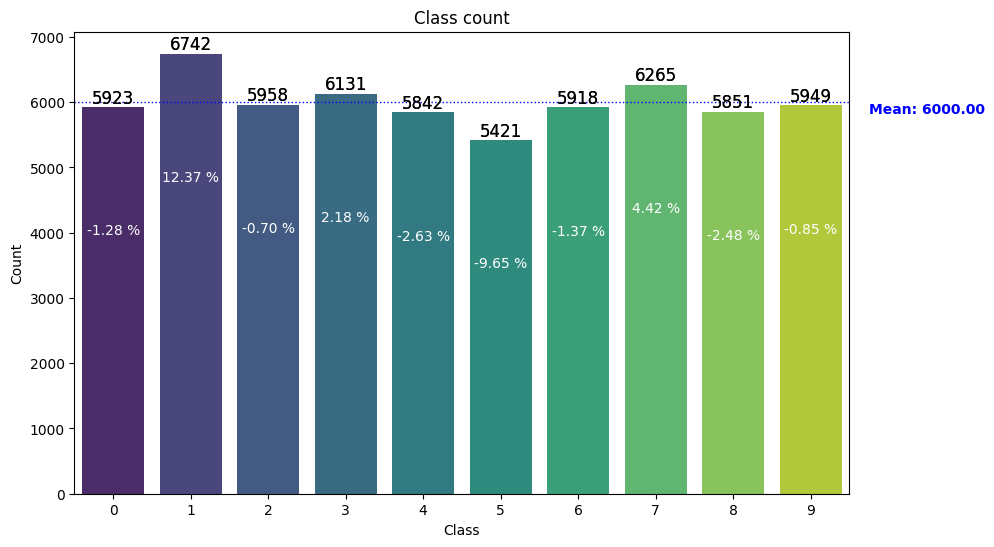

Etiquetas del Dataset: [0 1 2 3 4 5 6 7 8 9]
Cantidad de elementos por etiqueta: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Cantidad promedio por etiqueta: 6000.0
Desviaciones estándar de la media: [-1.283, 12.367, -0.7, 2.183, -2.633, -9.65, -1.367, 4.417, -2.483, -0.85]


In [4]:
labels, values = np.unique(y_train, return_counts = True)

data = pd.DataFrame({'Labels': labels, 'Values': values})

plt.figure(figsize=(10, 6)) 
sns.barplot(x='Labels', y='Values', data=data, palette='viridis')

# Add labels to each bar
for index, value in enumerate(values):
    plt.text(index, value + 0.5,  # x and y coordinates
             f'{value}',          # The label text
             ha='center',         # Horizontal alignment
             va='bottom',         # Vertical alignment
             fontsize=12,         # Font size
             color='black')       # Font color

# Calculate the mean of the values
mean_value = sum(values) / len(values)

# Calculate the standard deviation of the values
std_dev = np.std(values, ddof=1)  # Using Bessel's correction (ddof=1)

# Calculate the absolute deviation from the mean for each value
#deviations = [np.std(values) for value in values]
deviations = [np.round(((value - mean_value) / mean_value) * 100, 3) for value in values]

# Add labels to each bar
for index, (value, deviation) in enumerate(zip(values, deviations)):
    plt.text(index, value + 0.5,  # x and y coordinates for the value label
             f'{value}',          # The value label text
             ha='center',         # Horizontal alignment
             va='bottom',         # Vertical alignment
             fontsize=12,         # Font size
             color='black')       # Font color
    
    # Add the deviation from the mean
    plt.text(index, value - 2000,  # x and y coordinates for the deviation label, slightly below the bar
             f'{deviation:.2f} %',  # The deviation label text
             ha='center',          # Horizontal alignment
             va='bottom',          # Vertical alignment
             fontsize=10,          # Font size
             color='white')         # Font color
    
# Add a horizontal line for the mean value
plt.axhline(mean_value, color='blue', linestyle='dotted', linewidth=1, label=f'Mean Value ({mean_value:.2f})')

# Annotate the mean line
plt.text(len(labels)+0.5, mean_value + 0.5,  # Position of the annotation
         f'Mean: {mean_value:.2f}',          # The text of the annotation
         color='blue',                        # Text color
         ha='center',                        # Horizontal alignment
         va='top',                        # Vertical alignment
         fontsize=10,                        # Font size
         weight='bold')                      # Font weight
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class count')


plt.show()

print(f'Etiquetas del Dataset: {labels}')
print(f'Cantidad de elementos por etiqueta: {values}')
print(f'Cantidad promedio por etiqueta: {mean_value}')
print(f'Desviaciones estándar de la media: {deviations}')

El dataset parece bastante bien balanceado (es esperable, es MNIST!)

### mostramos una imagen de cada digito:

In [5]:
# Buscamos el primer representante de cada clase, es decir el primer index de cada etiqueta en y_train
class_representative_indexes = {}
y_train_df = pd.DataFrame({'Label':y_train})
for label in labels:
    class_representative_indexes[label] = y_train_df[y_train_df.Label == label].index[0]
class_representative_indexes

{0: 1, 1: 3, 2: 5, 3: 7, 4: 2, 5: 0, 6: 13, 7: 15, 8: 17, 9: 4}

La posición de la imagen a mostrar es la 1
La etiqueta de la imagen es: 0


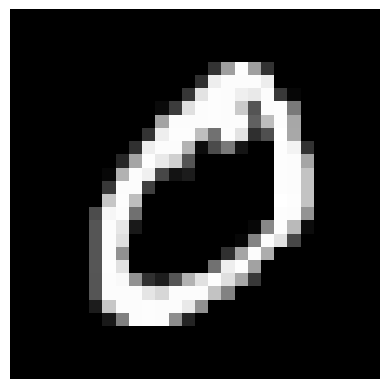

La posición de la imagen a mostrar es la 3
La etiqueta de la imagen es: 1


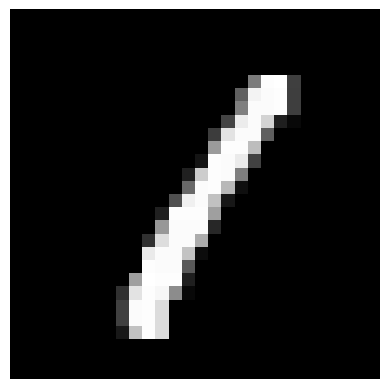

La posición de la imagen a mostrar es la 5
La etiqueta de la imagen es: 2


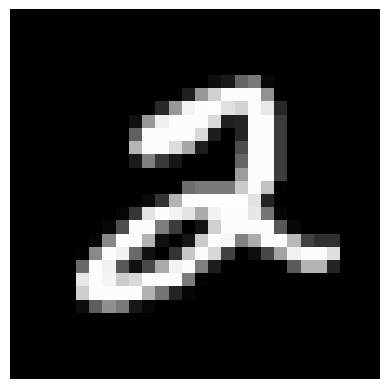

La posición de la imagen a mostrar es la 7
La etiqueta de la imagen es: 3


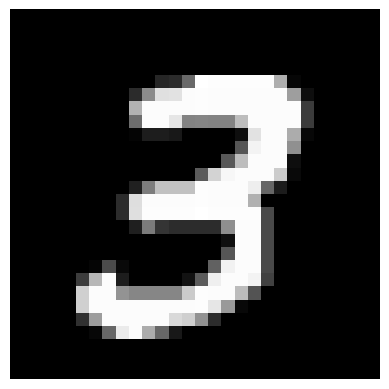

La posición de la imagen a mostrar es la 2
La etiqueta de la imagen es: 4


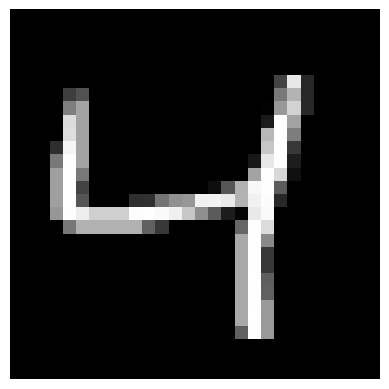

La posición de la imagen a mostrar es la 0
La etiqueta de la imagen es: 5


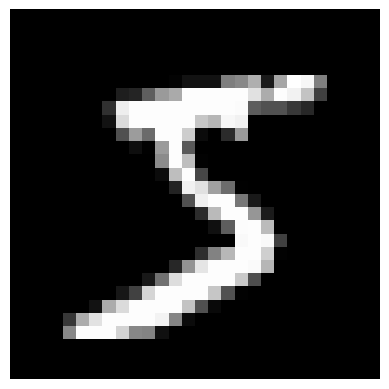

La posición de la imagen a mostrar es la 13
La etiqueta de la imagen es: 6


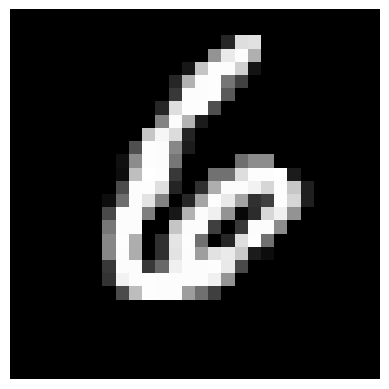

La posición de la imagen a mostrar es la 15
La etiqueta de la imagen es: 7


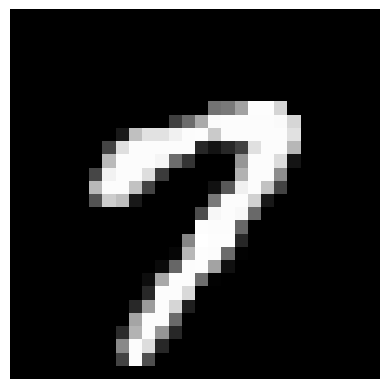

La posición de la imagen a mostrar es la 17
La etiqueta de la imagen es: 8


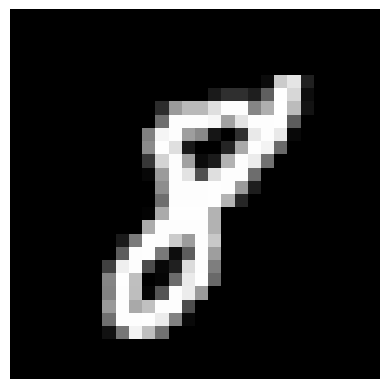

La posición de la imagen a mostrar es la 4
La etiqueta de la imagen es: 9


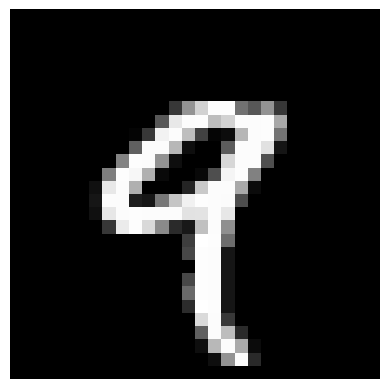

In [6]:
for i in class_representative_indexes.values():
    print(f'La posición de la imagen a mostrar es la {i}')
    print(f'La etiqueta de la imagen es: {y_train[i]}')
    plt.imshow(X_train[i, :, :], cmap = 'gray')
    plt.axis('off')
    plt.show()

## 2) Segmentación del dataset
simplemente usaremos la que viene como defecto en el dataset

# 3 y 4) Modelos y Métricas
### 3.1 Random Forest

In [7]:
#Importamos el clasificador y las métricas

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)


Transformamos los datasets en Data Frames, enviando al indíce el indice de cada imagen y a las columnas, cada uno de los 24x24 pixeles, de nuevo nos ayuda chat gpt:

In [8]:

# Function to transform an array of images into a DataFrame
def images_to_dataframe(images, dataset_type):
    # Flatten the images
    images_flattened = images.reshape(images.shape[0], -1)
    # Create column names
    pixel_columns = [f'pixel{i}' for i in range(images_flattened.shape[1])]
    # Create DataFrame
    df = pd.DataFrame(images_flattened, columns=pixel_columns)
    # Set the index name
    df.index.name = f'{dataset_type}_image_index'
    return df

# Transform X_train
X_train_df = images_to_dataframe(X_train, 'train')
# Transform X_test
X_test_df = images_to_dataframe(X_test, 'test')

# Transform y_train into a DataFrame
y_train_df = pd.DataFrame(y_train, columns=['label'])
y_train_df.index.name = 'train_image_index'

# Transform y_test into a DataFrame
y_test_df = pd.DataFrame(y_test, columns=['label'])
y_test_df.index.name = 'test_image_index'

In [12]:
#Entrenamos un Árbol de desición y predecimos:
rf = RandomForestClassifier(random_state=12, n_estimators=20,
                               class_weight="balanced", max_features="log2") #Elegimos random_state=12 porque soy hincha de Boca.
rf.fit(X_train_df, y_train)

y_pred=rf.predict(X_test_df)
proba_pred_test=rf.predict_proba(X_test_df)
print('Predicciones RF: ', y_pred)
print('Verdaderos:', y_test)

print(f"RF Accuracy: {rf.score(X_test_df, y_test)}")

Predicciones RF:  [7 2 1 ... 4 5 6]
Verdaderos: [7 2 1 ... 4 5 6]
RF Accuracy: 0.9537


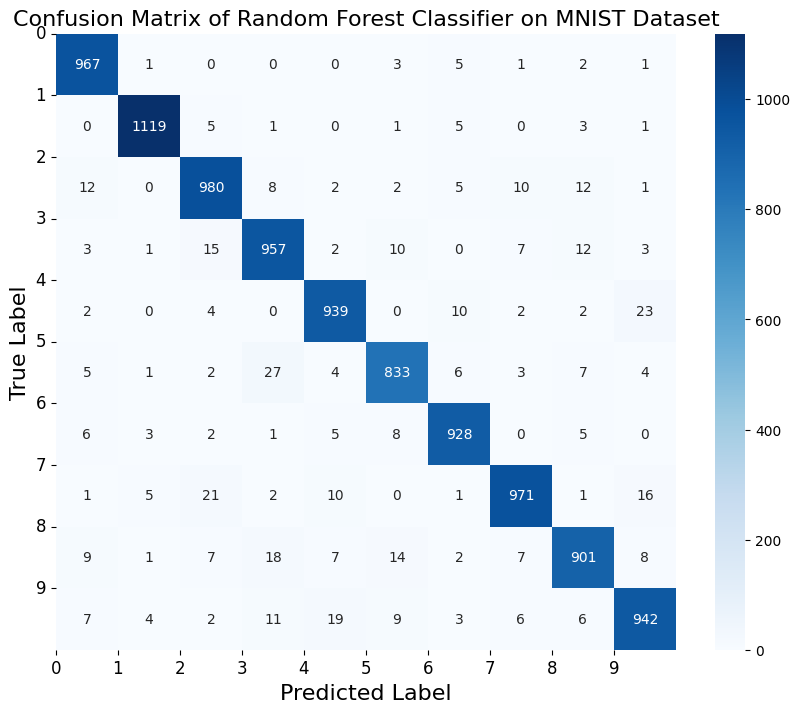

In [23]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
#sns.heatmap(conf_matrix, annot=conf_matrix.rank(axis="columns"), fmt='d', xticklabels=range(10), yticklabels=range(10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix of Random Forest Classifier on MNIST Dataset', fontsize=16)
plt.xticks(ticks=np.arange(10), labels=[f'{i}' for i in range(10)], fontsize=12)
plt.yticks(ticks=np.arange(10), labels=[f'{i}' for i in range(10)], fontsize=12, rotation=0)
plt.show()

Le fue MUY bien al random forest. En caso de tener clases desbalanceadas, deberiamos usar una media armónica (el F1) como métrica, pero teniendo clases tan bien balanceadas, el accuracy es una métrica razonable, nos basta que el modelo le "pegue" seguido para concluir que es bueno. Esto no es así en dataset desbalanceados: Si tuviesemos una clase que representase el 90% del dataset, un clasificador naive que siempre devuelva la etiqueta de esa clase tendría una accuracy del 90% y sería pésimo.

## 3.2 Redes Neuronales

In [44]:
X_train.shape

(60000, 28, 28)

In [24]:
y_train_CNN = keras.utils.to_categorical(y_train)
y_test_CNN = keras.utils.to_categorical(y_test)

In [45]:
Imagen_de_entrada = layers.Input(shape = (32, 28, 1))

In [46]:
X = layers.Conv2D(filters = 12, kernel_size = (3, 3), activation = None)(Imagen_de_entrada)

In [47]:
X = layers.MaxPooling2D(pool_size = (2, 2))(X)

In [48]:
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X)

X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

Flatten = layers.Flatten()(X)

In [49]:
X = layers.Dense(256, activation = "sigmoid")(Flatten)

X = layers.Dense(64, activation = "sigmoid")(X)

Salida = layers.Dense(units = 10, activation = 'softmax')(Flatten)

In [50]:
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [51]:
X_train.shape

(60000, 28, 28)

In [ ]:
Historia = Red_Neuronal.fit(x = X_train, y = y_train_CNN, epochs = 9, batch_size = 32, validation_data = (X_test, y_test_CNN))

Epoch 1/10


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7340 - loss: 0.8130 - val_accuracy: 0.9718 - val_loss: 0.0903
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9541 - loss: 0.1505 - val_accuracy: 0.9827 - val_loss: 0.0574
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9683 - loss: 0.1029 - val_accuracy: 0.9862 - val_loss: 0.0496
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9727 - loss: 0.0875 - val_accuracy: 0.9879 - val_loss: 0.0430
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9773 - loss: 0.0752 - val_accuracy: 0.9893 - val_loss: 0.0372
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9794 - loss: 0.0662 - val_accuracy: 0.9889 - val_loss: 0.0352
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9826 - loss: 0.0580 - val_accuracy: 0.9894 - val_loss: 0.0356
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9836 - loss: 0.0514 - val_accurac

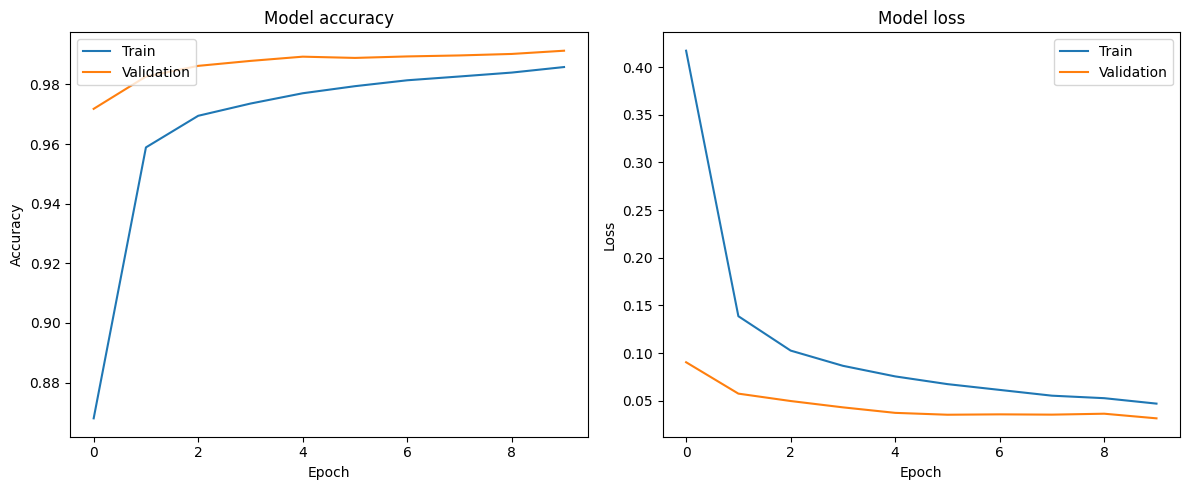

In [53]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN architecture
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=10, 
                    validation_split=0.2, 
                    verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot the training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Import images

Dimensiones de la imagen:     (240, 200, 3)


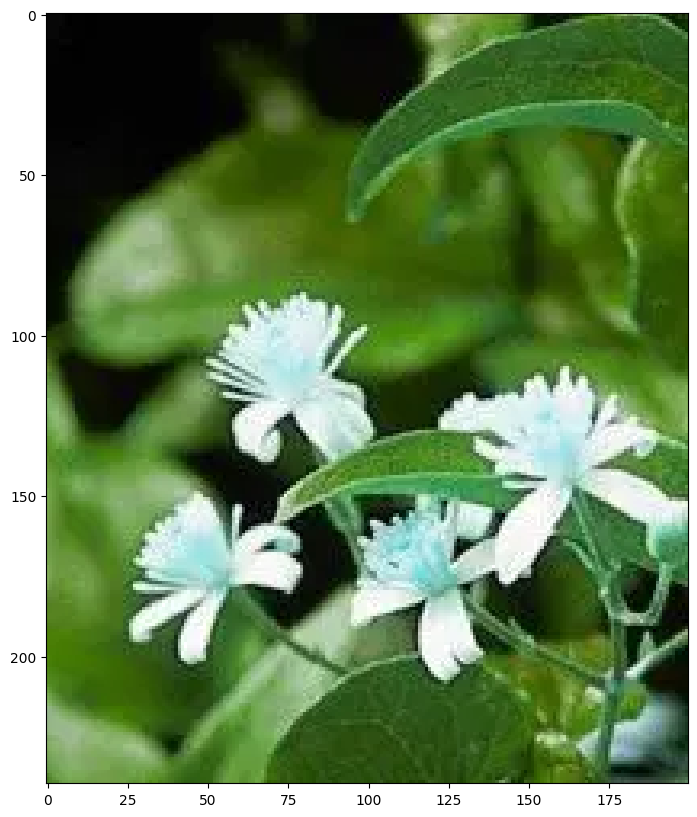

In [ ]:
flores_path = rf'flores.png'
flores = cv2.imread(flores_path)

print('Dimensiones de la imagen:    ', flores.shape)
plt.figure(figsize=(18,10))
plt.imshow(flores)

## Binarization

In [ ]:
flores_monochrome = cv2.imread(flores_path, 0)

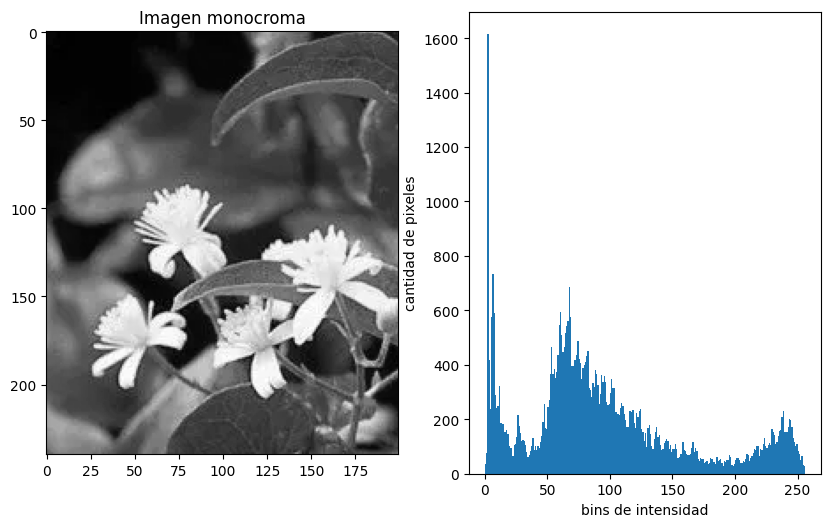

In [ ]:
# Histogram 

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
axs=axs.ravel()
fig.set_figheight(6)
fig.set_figwidth(10)
axs[0].imshow(flores_monochrome, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('Imagen monocroma')

axs[1].hist(flores_monochrome[:,:].ravel(), 256,[0,256] )
axs[1].set_xlabel('bins de intensidad')
axs[1].set_ylabel('cantidad de pixeles')

plt.show()

### Umbral a ojo

Pareciera que 40 y 200 son valores potenciales para el threshold de la binarización. Veamos

In [ ]:
ret_40,binaria_40 = cv2.threshold(flores_monochrome,40,255,cv2.THRESH_BINARY)
ret_200,binaria_200 = cv2.threshold(flores_monochrome,200,255,cv2.THRESH_BINARY)

Text(0.5, 1.0, 'Umbral = 200')

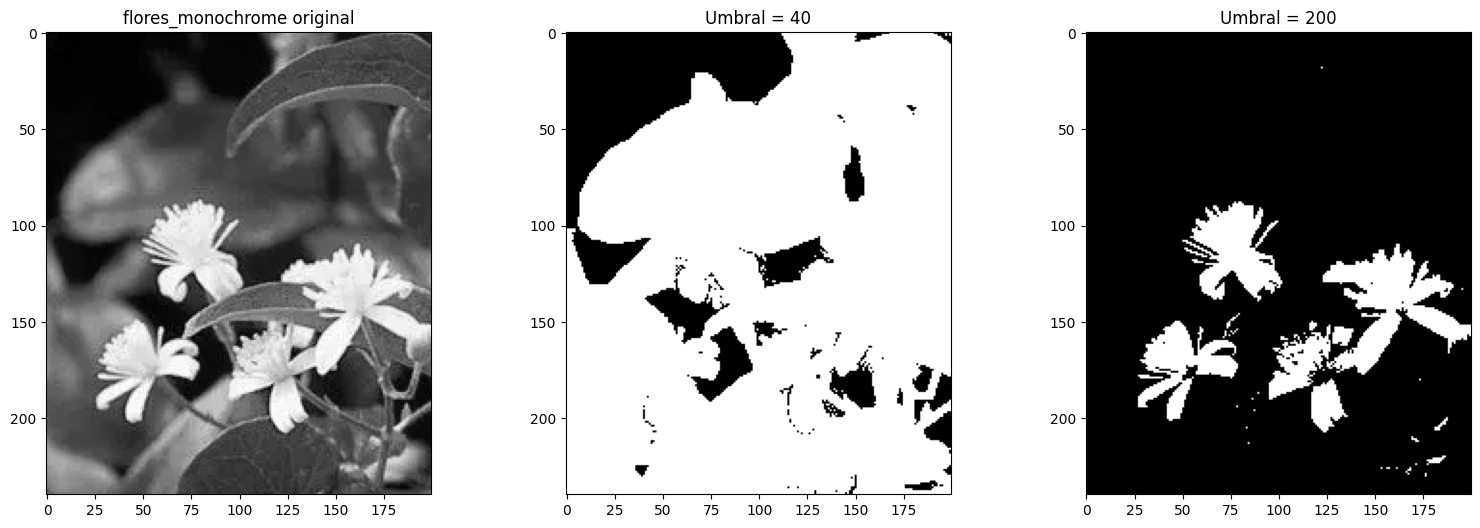

In [ ]:

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(6)
fig.set_figwidth(19)
axs[0].imshow(flores_monochrome, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('flores_monochrome original')
axs[1].imshow(binaria_40, cmap='gray',vmin=0 ,vmax=255)
axs[1].set_title('Umbral = 40')
axs[2].imshow(binaria_200, cmap='gray',vmin=0 ,vmax=255)
axs[2].set_title('Umbral = 200')

Claramente si queremos separar solo las flores, 200 es el valor más conveniente

### Binarización Automática

Veamos que dice el metodo OTSU

In [ ]:
ret0,binaria0 = cv2.threshold(flores_monochrome,0,255,cv2.THRESH_OTSU)
print('umbral calculado por Otsu:', ret0)

umbral calculado por Otsu: 129.0


Text(0.5, 1.0, 'Binaria con umbral Otsu (=129.0)')

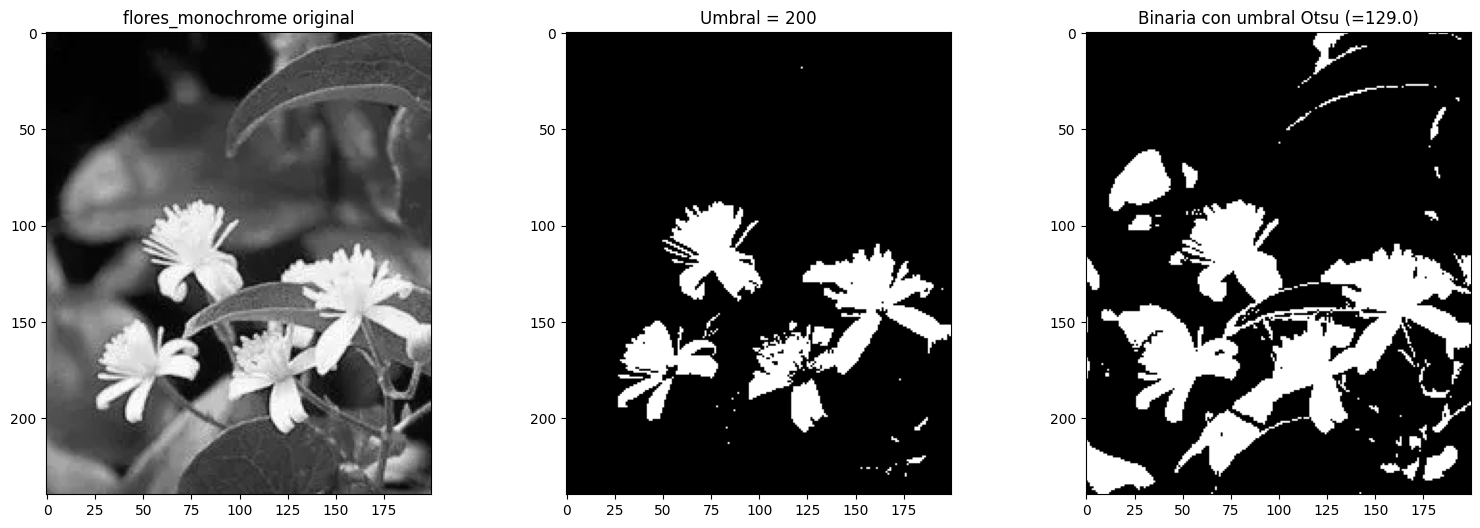

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(6)
fig.set_figwidth(19)
axs[0].imshow(flores_monochrome, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('flores_monochrome original')
axs[1].imshow(binaria_200, cmap='gray',vmin=0 ,vmax=255)
axs[1].set_title('Umbral = 200')
axs[2].imshow(binaria0, cmap='gray',vmin=0 ,vmax=255)
axs[2].set_title('Binaria con umbral Otsu (=129.0)')


Parece que el valor elegido a Mano es mejor. Las flores son sencillamente más claras que el resto de la imagen, si elegimos un umbral como el de Otsu, terminamos separando también los bordes más brillantes de las hojas, que no nos interesan.

# Clustering

In [ ]:
#!pip install pillow
import PIL
from PIL import Image
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from collections import Counter

In [ ]:
#Usando la recomendación de SO

'''
colourImg = Image.open("flores.png")
colourPixels = colourImg.convert("RGB")
colourArray = np.array(colourPixels.getdata()).reshape(colourImg.size + (3,))
indicesArray = np.moveaxis(np.indices(colourImg.size), 0, 2)
allArray = np.dstack((indicesArray, colourArray)).reshape((-1, 5))


flores_df0 = pd.DataFrame(allArray, columns=["columna", "fila","rojo","verde","azul"]) #las arma en orden distinto al otro metodo
flores_df0 = flores_df0[["fila", "columna","rojo","verde","azul"]]

'''

# Funciona pero da un df con un orden distinto al que tenemos usando el codigo de la clase, nos quedamos con ese.

'\ncolourImg = Image.open("flores.png")\ncolourPixels = colourImg.convert("RGB")\ncolourArray = np.array(colourPixels.getdata()).reshape(colourImg.size + (3,))\nindicesArray = np.moveaxis(np.indices(colourImg.size), 0, 2)\nallArray = np.dstack((indicesArray, colourArray)).reshape((-1, 5))\n\n\nflores_df0 = pd.DataFrame(allArray, columns=["columna", "fila","rojo","verde","azul"]) #las arma en orden distinto al otro metodo\nflores_df0 = flores_df0[["fila", "columna","rojo","verde","azul"]]\n\n'

No quedan iguales, por las dudas usamos el mismo que en la notebook 10, aunque no es mas que un reordenamiento de la matriz

Chequeamos:

In [ ]:

imagen = flores.copy()
dims=imagen.shape

cant_filas=dims[0]
cant_columnas=dims[1]
ind=np.indices((cant_filas,cant_columnas)) # arreglo con matriz de filas y  matriz de columnas

cant_pixeles=cant_filas*cant_columnas

#columnas=np.zeros([cant_pixeles,5],dtype='int')

datos=np.zeros([cant_pixeles,5],dtype='int')

datos[:,0]=ind[0].flatten() #filas
datos[:,1]=ind[1].flatten() #columnas
datos[:,2]=imagen[:,:,0].flatten() #rojo
datos[:,3]=imagen[:,:,1].flatten() # verde
datos[:,4]=imagen[:,:,2].flatten() # azul

flores_df = pd.DataFrame(datos, columns=["fila", "columna","rojo","verde","azul"])

print(flores_df.shape)
print('Base de pixeles:')
flores_df.head()

(48000, 5)
Base de pixeles:


,fila,columna,rojo,verde,azul
0,0,0,7,7,7
1,0,1,7,7,7
2,0,2,7,7,7
3,0,3,7,7,7
4,0,4,8,8,8


# Baseline clustering
Probamos un clustering con k-means sin agregar features para tener de referencia.<br>
Elegimos k=3 pues requerimos seccionar la imagen en 3: Flores, Hojas y fondo.<br>
No esta

In [ ]:
kmeans_3 = KMeans(n_clusters=3)
df_clusters=flores_df.copy()

kmeans_3.fit(df_clusters)

df_clusters['kmedias']=kmeans_3.labels_
df_clusters.head()

,fila,columna,rojo,verde,azul,kmedias
0,0,0,7,7,7,0
1,0,1,7,7,7,0
2,0,2,7,7,7,0
3,0,3,7,7,7,0
4,0,4,8,8,8,0


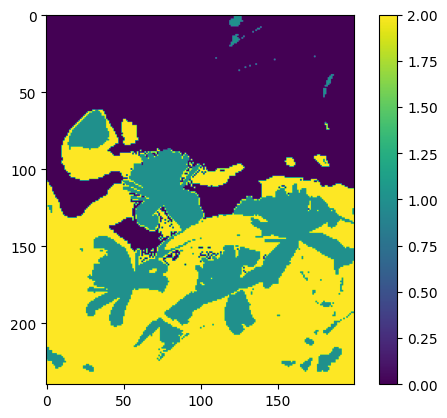

In [ ]:
imagen_kmedias=np.reshape(kmeans_3.labels_, (cant_filas,cant_columnas))
plt.imshow(imagen_kmedias)
#plt.imshow(imagen_kmedias, cmap='gray')
#plt.title('imagen TRInaria')
plt.colorbar()
plt.show()

### Baseline estandarizado

In [ ]:
from sklearn import preprocessing

std_scale=preprocessing.StandardScaler().fit(flores_df) #resta la media  de cada columna y luego divide por el desvío
flores_df_scaled=std_scale.transform(flores_df) # media 0 y desvío 1 por columnas

In [ ]:
scaled_features_df = pd.DataFrame(flores_df_scaled, index=flores_df.index, columns=flores_df.columns)

In [ ]:
kmeans_3_scaled = KMeans(n_clusters=3)

kmeans_3_scaled.fit(flores_df_scaled) #fiteo, ejecuto el algoritmo usando la base estandarizada o normalizada por columnas

scaled_features_df['kmedias_base_estadarizada']=kmeans_3_scaled.labels_
scaled_features_df.head()

,fila,columna,rojo,verde,azul,kmedias_base_estadarizada
0,-1.724849,-1.723412,-1.202049,-1.616492,-0.756049,0
1,-1.724849,-1.706091,-1.202049,-1.616492,-0.756049,0
2,-1.724849,-1.688771,-1.202049,-1.616492,-0.756049,0
3,-1.724849,-1.671450,-1.202049,-1.616492,-0.756049,0
4,-1.724849,-1.654129,-1.185993,-1.601517,-0.742437,0


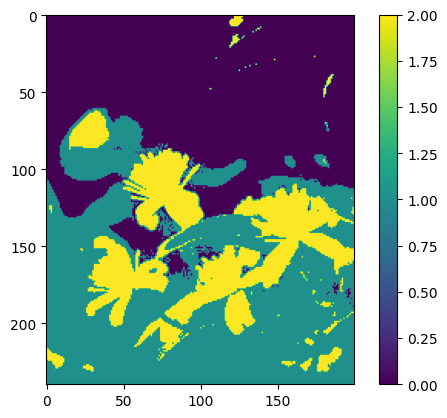

In [ ]:
imagen_kmedias=np.reshape(kmeans_3_scaled.labels_, (cant_filas,cant_columnas))
plt.imshow(imagen_kmedias)
#plt.imshow(imagen_kmedias, cmap='gray')
#plt.title('imagen TRInaria')
plt.colorbar()
plt.show()

Y no queda distinto. Los valores de las 5 features que teniamos oscilaban entre 1 y 255, entonces estandarizar de esta manera no cambia nada.

## Feature eng

In [ ]:
flores_clustering = flores_df.copy()

### Color diff

In [ ]:
flores_clustering['dif_r-g']=flores_clustering["rojo"]-flores_clustering["verde"]
flores_clustering['dif_g-b']=flores_clustering["verde"]-flores_clustering["azul"]
flores_clustering['dif_b-r']=flores_clustering["azul"]-flores_clustering["rojo"]

### Sobel Filter

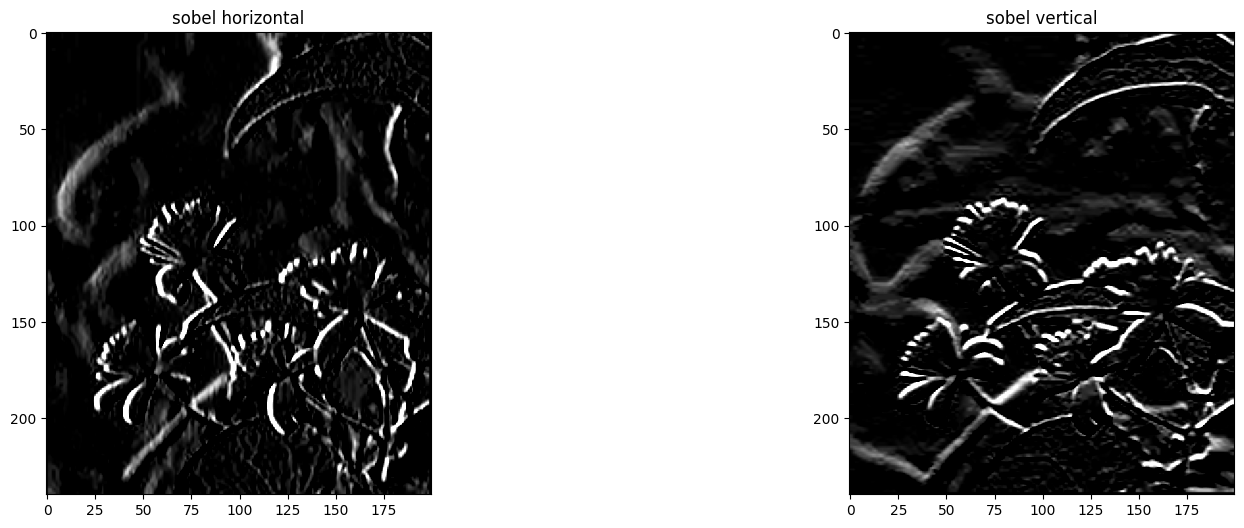

In [ ]:
img = cv2.imread('flores.png', 0)
rows, cols = img.shape
sobelksize = 3
sobel_horizontal = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobelksize)
sobel_vertical = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobelksize)

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(19)

axs[0].imshow(sobel_horizontal, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('sobel horizontal')
axs[1].imshow(sobel_vertical, cmap='gray',vmin=0 ,vmax=255)
axs[1].set_title('sobel vertical')

plt.show()  

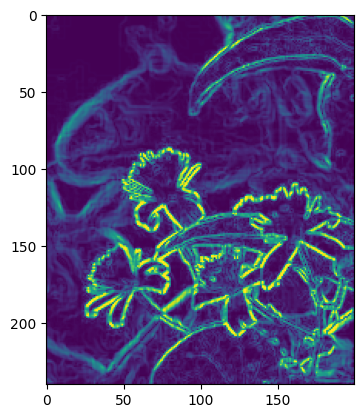

In [ ]:
x = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=3, scale=1)
y = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=3, scale=1)
absx= cv2.convertScaleAbs(x)
absy = cv2.convertScaleAbs(y)
sobel_edge = cv2.addWeighted(absx, 0.5, absy, 0.5,0)
plt.imshow(sobel_edge)  

In [ ]:
flores_clustering['sobel_horizontal'] = sobel_horizontal.flatten()
flores_clustering['sobel_vertical'] = sobel_vertical.flatten()
flores_clustering['sobel_edge'] = sobel_edge.flatten()

### Gabor Filter
Acá mucha idea no tengo de cómo funciona, leí la entrada de Wikipedia y le pedí el codigo a Chat GPT, no me doy cuenta de forma intuitiva si la resultante tiene sentido o no. No pude ver todas las clases, en las notebooks no lo vi escrito. Lo agregaremos al modelo y veremos.

In [ ]:
from scipy import ndimage

# Function to apply Gabor filter
def apply_gabor_filter(image, ksize=31, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)
    return filtered_image

# Load an example image (replace 'image_path' with your image file path)
image_path = 'flores.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gabor filter to the image
gabor_filtered_image = apply_gabor_filter(image)

# Convert filtered image to a 1D array to store in DataFrame
gabor_filtered_image_flat = gabor_filtered_image.flatten()

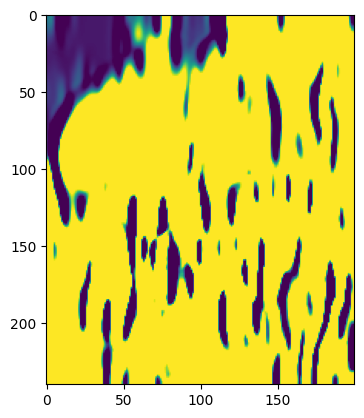

In [ ]:
gabor_filtered_image
plt.imshow(gabor_filtered_image)  

In [ ]:
flores_clustering['gabor_texture'] = gabor_filtered_image_flat

Creadas las features, nos queda así el df:

In [ ]:
flores_clustering

,fila,columna,rojo,verde,azul,dif_r-g,dif_g-b,dif_b-r,sobel_horizontal,sobel_vertical,sobel_edge,gabor_texture
0,0,0,7,7,7,0,0,0,0.0,0.0,0,104
1,0,1,7,7,7,0,0,0,0.0,0.0,0,109
2,0,2,7,7,7,0,0,0,0.0,0.0,0,117
3,0,3,7,7,7,0,0,0,4.0,0.0,2,113
4,0,4,8,8,8,0,0,0,-4.0,0.0,2,86
...,...,...,...,...,...,...,...,...,...,...,...,...
47995,239,195,70,97,70,-27,27,0,66.0,0.0,33,255
47996,239,196,84,115,85,-31,30,1,46.0,0.0,23,255
47997,239,197,76,110,77,-34,33,1,12.0,0.0,6,255
47998,239,198,82,116,83,-34,33,1,66.0,0.0,33,255


Estandarizamos, ahora sí

In [ ]:
flores_clustering_df = flores_clustering.copy()

std_scale=preprocessing.StandardScaler().fit(flores_clustering_df) #resta la media  de cada columna y luego divide por el desvío
flores_clustering_df_scaled=std_scale.transform(flores_clustering_df) # media 0 y desvío 1 por columnas

In [ ]:
scaled_features_df = pd.DataFrame(flores_clustering_df_scaled, index=flores_clustering_df.index, columns=flores_clustering_df.columns)

In [ ]:
kmeans_3_scaled = KMeans(n_clusters=3)

kmeans_3_scaled.fit(scaled_features_df) #fiteo, ejecuto el algoritmo usando la base estandarizada o normalizada por columnas

scaled_features_df['kmedias_base_estadarizada']=kmeans_3_scaled.labels_
scaled_features_df.head()

,fila,columna,rojo,verde,azul,dif_r-g,dif_g-b,dif_b-r,sobel_horizontal,sobel_vertical,sobel_edge,gabor_texture,kmedias_base_estadarizada
0,-1.724849,-1.723412,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.001878,-0.011341,-0.787903,-1.064299,1
1,-1.724849,-1.706091,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.001878,-0.011341,-0.787903,-1.011808,1
2,-1.724849,-1.688771,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.001878,-0.011341,-0.787903,-0.927823,1
3,-1.724849,-1.671450,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,0.036558,-0.011341,-0.752742,-0.969816,1
4,-1.724849,-1.654129,-1.185993,-1.601517,-0.742437,1.850076,-1.51665,0.764603,-0.040313,-0.011341,-0.752742,-1.253266,1


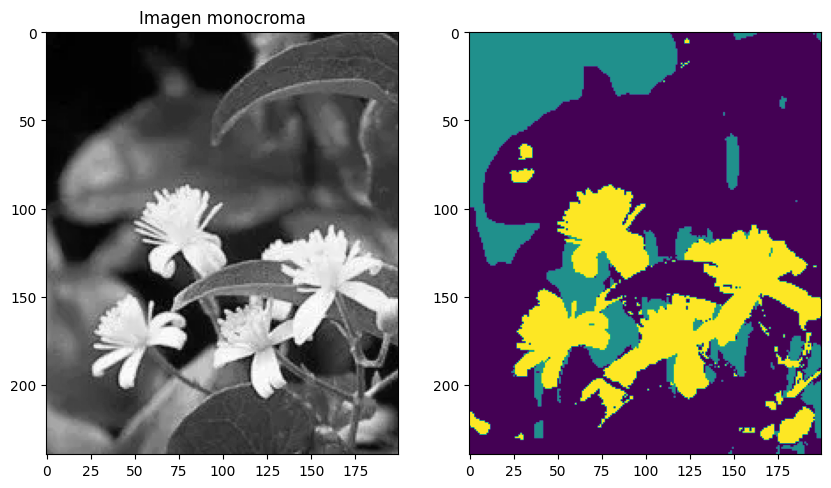

In [ ]:
imagen_kmedias=np.reshape(kmeans_3_scaled.labels_, (cant_filas,cant_columnas))

# Histogram 

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
axs=axs.ravel()
fig.set_figheight(6)
fig.set_figwidth(10)
axs[0].imshow(flores_monochrome, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('Imagen monocroma')

axs[1].imshow(imagen_kmedias)
#plt.imshow(imagen_kmedias, cmap='gray')
#plt.title('imagen TRInaria')


Probemos dropeando las columnas de sobel_horizontal y sobel_vertical a ver si mejora:

In [ ]:
scaled_features_df = scaled_features_df.drop(columns=['sobel_horizontal', 'sobel_vertical'])

kmeans_3_scaled = KMeans(n_clusters=3)
kmeans_3_scaled.fit(scaled_features_df) #fiteo, ejecuto el algoritmo usando la base estandarizada o normalizada por columnas
scaled_features_df['kmedias_base_estadarizada']=kmeans_3_scaled.labels_
scaled_features_df.head()

,fila,columna,rojo,verde,azul,dif_r-g,dif_g-b,dif_b-r,sobel_edge,gabor_texture,kmedias_base_estadarizada
0,-1.724849,-1.723412,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.787903,-1.064299,1
1,-1.724849,-1.706091,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.787903,-1.011808,1
2,-1.724849,-1.688771,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.787903,-0.927823,1
3,-1.724849,-1.671450,-1.202049,-1.616492,-0.756049,1.850076,-1.51665,0.764603,-0.752742,-0.969816,1
4,-1.724849,-1.654129,-1.185993,-1.601517,-0.742437,1.850076,-1.51665,0.764603,-0.752742,-1.253266,1


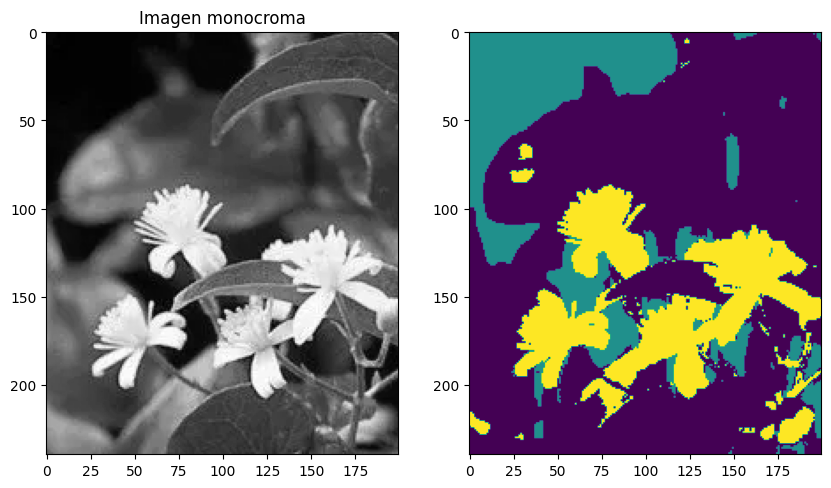

In [ ]:
imagen_kmedias=np.reshape(kmeans_3_scaled.labels_, (cant_filas,cant_columnas))

# Histogram 

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
axs=axs.ravel()
fig.set_figheight(6)
fig.set_figwidth(10)
axs[0].imshow(flores_monochrome, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('Imagen monocroma')

axs[1].imshow(imagen_kmedias)
#plt.imshow(imagen_kmedias, cmap='gray')
#plt.title('imagen TRInaria')


El numero de features no justifica usar un PCA para seleccionar las mas relevantes.

## Grafico Comparativo

Text(0.5, 1.0, 'Imagen binarizada')

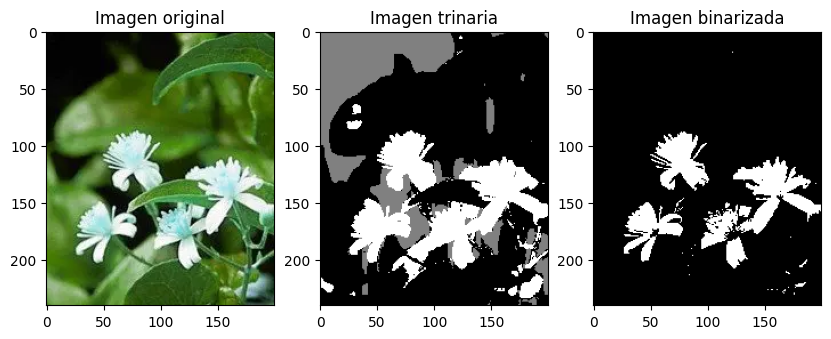

In [ ]:
imagen_kmedias=np.reshape(kmeans_3_scaled.labels_, (cant_filas,cant_columnas))

# Histogram 

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False)
axs=axs.ravel()
fig.set_figheight(6)
fig.set_figwidth(10)
axs[0].imshow(flores, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('Imagen original')
axs[1].imshow(imagen_kmedias, cmap='gray')
axs[1].set_title('Imagen trinaria')
axs[2].imshow(binaria_200, cmap='gray')
axs[2].set_title('Imagen binarizada')



El binarizado captura muchísimo mejor las flores blancas con respecto a todo lo demás, mientras que k-means pudo en gran medida diferenciar las hojas del fondo y en menor medida las flores de las hojas. Sería ideal poder separar las flores primero con binarización y las hojas del fondo vía k-means, luego "restar" las flores de las hojas y así tendríamos una segmentación ideal.